In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50
from fastai.models.unet import *
from torch import nn
from PIL import Image as PILImage

import json

torch.backends.cudnn.benchmark=True

torch.cuda.is_available()

True

# Data

## Definition

In [2]:
LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",   
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  , 
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",  
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}

In [3]:
class MultiBandMultiLabelDataset(Dataset):
    BANDS_NAMES = ['_red.png','_green.png','_blue.png','_yellow.png']
    
    def __len__(self):
        return len(self.images_df)
    
    def __init__(self, images_df, 
                 base_path, 
                 image_transform, 
                 augmentator=None,
                 train_mode=True    
                ):
        if not isinstance(base_path, pathlib.Path):
            base_path = pathlib.Path(base_path)
            
        self.images_df = images_df.copy()
        self.image_transform = image_transform
        self.augmentator = augmentator
        self.images_df.Id = self.images_df.Id.apply(lambda x: base_path / x)
        self.mlb = MultiLabelBinarizer(classes=list(LABEL_MAP.keys()))
        self.train_mode = train_mode

    def __getitem__(self, index):
        y = None
        X = self._load_multiband_image(index)
        if self.train_mode:
            y = self._load_multilabel_target(index)
        
        # augmentator can be for instance imgaug augmentation object
        if self.augmentator is not None:
            X = self.augmentator(X)
        X = self.image_transform(X)
            
        return X, y 
        
    def _load_multiband_image(self, index):
        row = self.images_df.iloc[index]
        image_bands = []
        for band_name in self.BANDS_NAMES:
            p = str(row.Id.absolute()) + band_name
            pil_channel = Image.open(p)
            image_bands.append(pil_channel)
            
        # lets pretend its a RBGA image to support 4 channels
        band4image = Image.merge('RGBA', bands=image_bands)
        return band4image
    
    def _load_multilabel_target(self, index):
        return list(map(int, self.images_df.iloc[index].Target.split(' ')))
    
    def collate_func(self, batch):
        labels = None
        images = [x[0] for x in batch]
        
        if self.train_mode:
            labels = [x[1] for x in batch]
            labels_one_hot  = self.mlb.fit_transform(labels)
            labels = torch.FloatTensor(labels_one_hot)
        
        return torch.stack(images)[:,:4,:,:], labels

## Instances

In [4]:
import pathlib
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader

In [5]:
PATH = pathlib.Path('data')

In [6]:
sz = 128
bs = 8

In [7]:
PATH_TO_IMAGES = 'data/train/'
PATH_TO_TEST_IMAGES = 'data/test/'
PATH_TO_META = 'data/train.csv'
SAMPLE_SUBMIT = 'data/sample_submission.csv'

train_df = pd.read_csv(PATH/'train.csv')
df_train, df_test  = train_test_split(train_df, test_size=0.2, random_state=33)
submit_df = pd.read_csv(PATH/'sample_submission.csv')

image_transform = transforms.Compose([
            transforms.Resize(sz),
            transforms.ToTensor(),])

train_set = MultiBandMultiLabelDataset(df_train, base_path=PATH_TO_IMAGES, image_transform=image_transform)
val_set = MultiBandMultiLabelDataset(df_test, base_path=PATH_TO_IMAGES, image_transform=image_transform)
submit_set = MultiBandMultiLabelDataset(submit_df, base_path=PATH_TO_TEST_IMAGES, train_mode=False, image_transform=image_transform)

train_load = DataLoader(train_set, collate_fn=train_set.collate_func, batch_size=bs, num_workers=6)
test_load = DataLoader(val_set, collate_fn=val_set.collate_func, batch_size=bs, num_workers=6)
submission_load = DataLoader(submit_set, collate_fn=submit_set.collate_func, batch_size=bs, num_workers=6)

In [8]:
def change_size(sz=128, bs=64):
    train_df = pd.read_csv(PATH/'train.csv')
    df_train, df_test  = train_test_split(train_df, test_size=0.2, random_state=33)
    submit_df = pd.read_csv(PATH/'sample_submission.csv')

    image_transform = transforms.Compose([
            transforms.Resize(sz),
            transforms.ToTensor(),])

    train_set = MultiBandMultiLabelDataset(df_train, base_path=PATH_TO_IMAGES, image_transform=image_transform)
    val_set = MultiBandMultiLabelDataset(df_test, base_path=PATH_TO_IMAGES, image_transform=image_transform)
    submit_set = MultiBandMultiLabelDataset(submit_df, base_path=PATH_TO_TEST_IMAGES, train_mode=False, image_transform=image_transform)

    train_load = DataLoader(train_set, collate_fn=train_set.collate_func, batch_size=bs, num_workers=6)
    test_load = DataLoader(val_set, collate_fn=val_set.collate_func, batch_size=bs, num_workers=6)
    submission_load = DataLoader(submit_set, collate_fn=submit_set.collate_func, batch_size=bs, num_workers=6)
    
    md = ModelData.from_dls(PATH, train_load, test_load, submission_load)
    return md

# Model

## Decoder

In [9]:
pretrained_settings = {
    'se_resnext50_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext101_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
},
}

class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride

In [10]:
class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        """
        Parameters
        ----------
        block (nn.Module): Bottleneck class.
            - For SENet154: SEBottleneck
            - For SE-ResNet models: SEResNetBottleneck
            - For SE-ResNeXt models:  SEResNeXtBottleneck
        layers (list of ints): Number of residual blocks for 4 layers of the
            network (layer1...layer4).
        groups (int): Number of groups for the 3x3 convolution in each
            bottleneck block.
            - For SENet154: 64
            - For SE-ResNet models: 1
            - For SE-ResNeXt models:  32
        reduction (int): Reduction ratio for Squeeze-and-Excitation modules.
            - For all models: 16
        dropout_p (float or None): Drop probability for the Dropout layer.
            If `None` the Dropout layer is not used.
            - For SENet154: 0.2
            - For SE-ResNet models: None
            - For SE-ResNeXt models: None
        inplanes (int):  Number of input channels for layer1.
            - For SENet154: 128
            - For SE-ResNet models: 64
            - For SE-ResNeXt models: 64
        input_3x3 (bool): If `True`, use three 3x3 convolutions instead of
            a single 7x7 convolution in layer0.
            - For SENet154: True
            - For SE-ResNet models: False
            - For SE-ResNeXt models: False
        downsample_kernel_size (int): Kernel size for downsampling convolutions
            in layer2, layer3 and layer4.
            - For SENet154: 3
            - For SE-ResNet models: 1
            - For SE-ResNeXt models: 1
        downsample_padding (int): Padding for downsampling convolutions in
            layer2, layer3 and layer4.
            - For SENet154: 1
            - For SE-ResNet models: 0
            - For SE-ResNeXt models: 0
        num_classes (int): Number of outputs in `last_linear` layer.
            - For all models: 1000
        """
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)
#         self.last_linear = nn.Linear(512*16, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']

In [11]:
def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [12]:
def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

## Model Functions

In [13]:
def get_resnext101(n_classes, image_channels=4):
    model = se_resnext50_32x4d()
    
    layer0_modules = [('conv1', nn.Conv2d(image_channels, 64, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True))]
    layer0 = nn.Sequential(OrderedDict(layer0_modules))
    
    last_linear = nn.Linear(1384448, n_classes)
    
    model.layer0 = layer0
    model.last_linear = last_linear
    
    for p in model.parameters():
        p.requires_grad = True
        
    return model 

In [14]:
def get_resnext101_learner(md):
    md = ModelData.from_dls(PATH, train_load, test_load, submission_load)
    resnext101 = to_gpu(get_resnext101(28,4))
    models = CustomModel(resnext101)
    learn = CustomLearner(md, models)
    
    learn.crit = nn.BCEWithLogitsLoss()
    learn.opt_fn = optim.Adam
    learn.metrics=[my_f1_score]
    return learn

In [15]:
def get_model(n_classes, image_channels=4):
    model = se_resnext50_32x4d(28, pretrained=None)
    
    layer0_modules = [('conv1', nn.Conv2d(image_channels, 64, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True))]
    layer0 = nn.Sequential(OrderedDict(layer0_modules))
    model.layer0 = layer0
    
    for p in model.parameters():
        p.requires_grad = True
    return model 

In [16]:
class CustomModel():
    def __init__(self,model,name='res50_4'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute=False):
        return [children(self.model)]

In [17]:
class CustomLearner(Learner):
    def get_layer_groups(self, precompute=False): 
        return self.models.get_layer_groups()
    
    def get_layer_opt(self, lrs, wds):
        return LayerOptimizer(self.opt_fn, self.get_layer_groups(), lrs, wds)

In [18]:
def get_learner(md):
    md = ModelData.from_dls(PATH, train_load, test_load, submission_load)
    res50_4 = to_gpu(get_model(28,4))
    models = CustomModel(res50_4)
    learn = CustomLearner(md, models)
    
    learn.crit = nn.BCEWithLogitsLoss()
    learn.opt_fn = optim.Adam
    learn.metrics=[my_f1_score]
    return learn

In [19]:
from sklearn.metrics import f1_score

def my_f1_score(y_pred, y_true):
    threshold = 0.2
    return f1_score(y_pred>0.2, y_true, average='micro')

# Test Model

In [21]:
md = change_size(512,8)
learn = get_resnext101_learner(md)

In [22]:
learn.crit = nn.BCEWithLogitsLoss()
learn.opt_fn = optim.Adam
learn.metrics=[my_f1_score]

 30%|██▉       | 931/3108 [02:02<04:46,  7.60it/s, loss=1.65] CPU times: user 1min 45s, sys: 16 s, total: 2min 1s
Wall time: 2min 2s


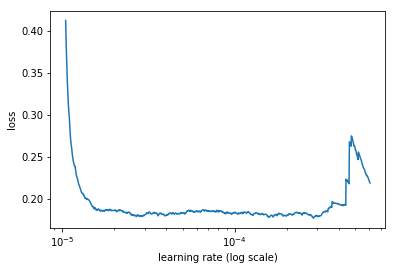

In [23]:
%%time
learn.lr_find()
learn.sched.plot()

In [65]:
learn.fit(5e-6,1,wds=1e-7,cycle_len=1,
          use_clr_beta=(10,10, 0.85, 0.9), 
          use_wd_sched=True)

  6%|▌         | 186/3108 [00:29<07:36,  6.40it/s, loss=0.226]

Process Process-19:
Process Process-24:
Process Process-20:
Traceback (most recent call last):
Process Process-22:
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-21:
Process Process-23:
Traceback (most recent call last):
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/eigenstir/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/eigenstir/anaconda3/lib/python3.6/m

KeyboardInterrupt: 

KeyboardInterrupt
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


# Train Model

## Small set

In [20]:
lr = 5e-5
arch = 'seresnext_101'

In [23]:
sz = 64
bs=128
md = change_size(sz, bs)
learn = get_resnext101_learner(md)

In [ ]:
learn.fit(lr,1,wds=1e-7,cycle_len=10,
          use_clr_beta=(10,10, 0.85, 0.9), 
          use_wd_sched=True, best_save_name=f'{arch}_{sz}')

In [ ]:
learn.load(f'{arch}_{sz}')

In [21]:
sz = 128
bs = 32
md = change_size(sz,bs)
learn = get_resnext101_learner(md)
learn.set_data(md)

In [ ]:
learn.fit(lr,1,wds=1e-7,cycle_len=10,
          use_clr_beta=(10,10, 0.85, 0.9), 
          use_wd_sched=True, best_save_name=f'{arch}_{sz}')

In [22]:
learn.load(f'{arch}_{sz}')

In [23]:
sz = 128
bs = 32
md = change_size(sz,bs)
learn = get_resnext101_learner(md)
learn.set_data(md)

In [24]:
learn.fit(lr,1,wds=1e-7,cycle_len=20,
          use_clr_beta=(10,10, 0.85, 0.9), 
          use_wd_sched=True, best_save_name=f'{arch}_{sz}')

 54%|█████▍    | 420/777 [02:36<02:12,  2.69it/s, loss=0.176]

Process Process-4:
Process Process-2:
Process Process-3:
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-6:
Traceback (most recent call last):
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-1:
Process Process-5:
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/eigenstir/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback

Traceback (most recent call last):
  File "/home/eigenstir/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-5b725465d677>", line 3, in <module>
    use_wd_sched=True, best_save_name=f'{arch}_{sz}')
  File "/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/learner.py", line 287, in fit
    return self.fit_gen(self.model, self.data, layer_opt, n_cycle, **kwargs)
  File "/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/learner.py", line 234, in fit_gen
    swa_eval_freq=swa_eval_freq, **kwargs)
  File "/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/model.py", line 129, in fit
    loss = model_stepper.step(V(x),V(y), epoch)
  File "/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/model.py", line 61, in step
    self.opt.step()
  File "/home/eigenstir/anaconda3/lib/python3.6/site-packages/torch/optim/adam.py", line 93

KeyboardInterrupt: 

  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/eigenstir/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
KeyboardInterrupt
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [ ]:
learn.load(f'{arch}_{sz}')

In [ ]:
sz = 512
bs = 8
md = change_size(sz,bs)
learn = get_resnext101_learner(md)
learn.set_data(md)

In [45]:
learn.fit(lr,1,wds=1e-7,cycle_len=70,
          use_clr_beta=(10,10, 0.85, 0.9), 
          use_wd_sched=True, best_save_name=f'{arch}_{sz}')

/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: Undefi

/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: Undefi

epoch      trn_loss   val_loss   my_f1_score 
    0      0.162408   0.165299   0.196964  


/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: Undefi

    1      0.153293   0.158582   0.263599  


/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: Undefi

    2      0.148921   0.154021   0.28057   


/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: Undefi

    3      0.145427   0.150492   0.287302  


/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: Undefi

    4      0.141756   0.146725   0.299962  


/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: Undefi

    5      0.137739   0.142723   0.331596  


/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


    6      0.132941   0.138491   0.364157  


/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


    7      0.127117   0.133928   0.395577  


/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


    8      0.121186   0.128818   0.43375   


/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


    9      0.115672   0.123991   0.466444  
    10     0.11091    0.120305   0.49589                       
    11     0.106779   0.117502   0.514246                      
    12     0.103008   0.115354   0.528858                      
    13     0.099546   0.113569   0.537859                       
    14     0.096228   0.112206   0.547333                       
    15     0.093133   0.111356   0.551448                       


/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


    16     0.090136   0.110646   0.557276  


/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


    17     0.087148   0.110224   0.559137  


/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


    18     0.084108   0.110027   0.564039  


/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


    19     0.081028   0.110091   0.565447  
    20     0.077855   0.110205   0.567279                       
    21     0.074686   0.110661   0.56828                        
    22     0.071333   0.111022   0.569296                       
    23     0.068041   0.111585   0.569885                       
    24     0.064577   0.112451   0.571933                       
    25     0.061219   0.113053   0.575155                       
    26     0.057749   0.114088   0.576379                       
    27     0.054077   0.114567   0.582635                       
    28     0.050188   0.117518   0.580725                       
    29     0.047754   0.120573   0.576452                       
    30     0.044061   0.123642   0.591334                       
    31     0.040444   0.125317   0.606845                       
    32     0.037092   0.128816   0.62468                        
    33     0.03458    0.14032    0.612583                       
    34     0.032469   0.141568   0.610503     

[0.24857315290434553, 0.6642273853029884]

## Just 512x512

In [20]:
lr = 5e-5
arch = 'seresnext_101'

In [21]:
sz = 512
bs = 2
md = change_size(sz,bs)
learn = get_resnext101_learner(md)
learn.set_data(md)

In [22]:
learn.fit(lr,1,wds=1e-7,cycle_len=100,
          use_clr_beta=(10,10, 0.85, 0.9), 
          use_wd_sched=True, best_save_name=f'{arch}_{sz}')

  9%|▉         | 1097/12429 [08:14<1:25:08,  2.22it/s, loss=0.183]

Process Process-4:
Process Process-6:
Process Process-5:
Process Process-3:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/eigenstir/anaconda3/lib/python3.6/multiprocessing/process.p

Traceback (most recent call last):
  File "/home/eigenstir/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-c1755109675c>", line 3, in <module>
    use_wd_sched=True, best_save_name=f'{arch}_{sz}')
  File "/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/learner.py", line 287, in fit
    return self.fit_gen(self.model, self.data, layer_opt, n_cycle, **kwargs)
  File "/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/learner.py", line 234, in fit_gen
    swa_eval_freq=swa_eval_freq, **kwargs)
  File "/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/model.py", line 129, in fit
    loss = model_stepper.step(V(x),V(y), epoch)
  File "/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/model.py", line 61, in step
    self.opt.step()
  File "/home/eigenstir/anaconda3/lib/python3.6/site-packages/torch/optim/adam.py", line 93

KeyboardInterrupt: 

KeyboardInterrupt
KeyboardInterrupt


# Prepare Submission

In [46]:
def make_submission_file(sample_submission_df, predictions):
    submissions = []
    for row in predictions:
        subrow = ' '.join(list([str(i) for i in np.nonzero(row)[0]]))
        submissions.append(subrow)
    
    sample_submission_df['Predicted'] = submissions
    sample_submission_df.to_csv('submission_FA.csv', index=None)
    
    return sample_submission_df

In [48]:
learn.load(f'{arch}_{sz}')

In [86]:
pred = learn.predict(is_test=True)

In [87]:
pred.shape

(11702, 28)

In [88]:
pred>0.2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ...,  True, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False]])

In [89]:
THRESHOLD = 0.2
p = pred>THRESHOLD

submission_file = make_submission_file(sample_submission_df=submit_df,
                     predictions=p)

NameError: name 'make_submission_file' is not defined

# TTA

In [ ]:
image_vflip = transforms.Compose([
            transforms.Resize(sz),
            transforms.RandomHorizontalFlip(p=1),
            transforms.ToTensor()])

image_hflip = transforms.Compose([
            transforms.Resize(sz),
            transforms.RandomVerticalFlip(p=1),
            transforms.ToTensor()])

class TestTimeDataset(MultiBandMultiLabelDataset):
    def check_flipped(self, flip):
        if flip==1:
            self.image_transform = image_vflip
        elif flip==2:
            self.image_transform = image_hflip

In [ ]:
submit_set = TestTimeDataset(submit_df, base_path=PATH_TO_TEST_IMAGES, train_mode=False, image_transform=image_transform)

In [ ]:
submission_load = DataLoader(submit_set, collate_fn=submit_set.collate_func, batch_size=bs, num_workers=6)

In [ ]:
pred_array = np.zeros((11702, 28),dtype=float)

In [ ]:
for o in [1,2,3]:
    print(str(o))
    submit_set.check_flipped(o)
    
    submission_load = DataLoader(submit_set, 
                                 collate_fn=submit_set.collate_func, 
                                 batch_size=16, num_workers=6)
    learn.load('res50_FA512')
    learn.data.test_dl = submission_load
    
    submission_predictions = learn.predict(is_test=True)
    pred_array = (pred_array + submission_predictions)/2